In [41]:
# Load general utilities
# ----------------------
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.axes as ax
import datetime
import numpy as np
import pickle
import time
import seaborn as sns
from sys import platform
import os

In [42]:
# This is the code you can use to open your pickle file
# Read the data and features from the pickle
final_data, discrete_features, continuous_features, ret_cols = pickle.load( open( "Data/clean_data.pickle", "rb" ) )

In [43]:
# Create the outcome
final_data["default"] = final_data.loan_status.isin(["Charged Off", "Default"])

In [44]:
# Create a feature for the length of a person's credit history at the
# time the loan is issued
final_data['cr_hist'] = (final_data.issue_d - final_data.earliest_cr_line) / np.timedelta64(1, 'M')
continuous_features.append('cr_hist')

In [45]:
from sklearn.preprocessing import MinMaxScaler

def minMaxScaleContinuous(continuousList):
    return pd.DataFrame(MinMaxScaler().fit_transform(final_data[continuousList])
                             ,columns=list(final_data[continuousList].columns)
                             ,index = final_data[continuousList].index)

def createDiscreteDummies(discreteList):
    return pd.get_dummies(final_data[discreteList], dummy_na = True, prefix_sep = "::", drop_first = False)

In [46]:
discrete_features_touse =['grade']


continuous_features_touse = ['int_rate']

In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# Create dummies for categorical features and concatenate with continuous features for X or predictor dataframe

# Use this line of code if you do not want to scale the continuous features
#X_continuous = data[continuous_features_touse]

# use this line if you want to scale the continuous features using the MinMaxScaler in the function defined above
X_continuous = minMaxScaleContinuous(continuous_features_touse)

# create numeric dummy features for the discrete features to be used in modeling
X_discrete = createDiscreteDummies(discrete_features_touse)


#split dataset in features and target variable
#concatenate the continuous and discrete features into one dataframe
X = pd.concat([X_continuous, X_discrete], axis = 1)

# this is the target variable 
target_col = "default"
y=final_data[target_col]


# create a test and train split of the transformed data
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, test_size=.4)

print("Population:\n",y.value_counts())
print("Train:\n", y_train.value_counts())
print("Test:\n", y_test.value_counts())


Population:
 False    623662
True     164031
Name: default, dtype: int64
Train:
 False    374090
True      98525
Name: default, dtype: int64
Test:
 False    249572
True      65506
Name: default, dtype: int64


In [48]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

''' These are just example parameter settings. You can change these parameters or add others.
    The grid search uses a scoring method of roc_auc. You can change that to another scoring method.
'''

parameters = {'penalty': ["l1"],
              'C'      : [0.1],
              'solver' : ['liblinear']
             }

print("Parameter grid:\n{}".format(parameters),'\n')

grid =  GridSearchCV(LogisticRegression(), parameters, cv=10, return_train_score=True, scoring='roc_auc', n_jobs=-1)

# perform grid search cv on training data.  The CV algorithm divides this into training and validation
lr_model = grid.fit(X_train, y_train)

print('best params ',lr_model.best_params_,'\n')
print('best estimator ',lr_model.best_estimator_,'\n')
print('best validation score ', lr_model.best_score_,'\n')
print('scoring method ', lr_model.scorer_)

print("Test set accuracy score: {:.7f}".format(lr_model.score(X_test, y_test)))

#saveModel('lr_model', lr_model)

Parameter grid:
{'penalty': ['l1'], 'C': [0.1], 'solver': ['liblinear']} 

best params  {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} 

best estimator  LogisticRegression(C=0.1, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False) 

best validation score  0.6867998257062851 

scoring method  make_scorer(roc_auc_score, needs_threshold=True)
Test set accuracy score: 0.6873750


In [49]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, fbeta_score, classification_report

'''Function to print model accuracy information'''

def printAccuracyInfo(model, X_test, y_test):
    print(y_test.value_counts())
    # Make predictions against the test set
    pred = lr_model.predict(X_test)
    # Show the confusion matrix
    ''' confusion matrix returned with Predicted as the Columns and Actual as the Rows
         PN  PP
         AN [tn  fp] 
         AP [fn  tp]
    '''
    # Show the confusion matrix
    print("confusion matrix:")
    print(confusion_matrix(y_test, pred))
    tn,fp,fn,tp=confusion_matrix(y_test, pred).ravel()
    print('tn: ',tn)
    print('fp: ',fp)
    print('fn: ',fn)
    print('tp: ',tp)

    # Find the accuracy scores of the predictions against the true classes
    print("accuracy: %0.3f" % accuracy_score(y_test, pred))
    print("recall: %0.3f" % recall_score(y_test, pred, pos_label=True))
    print("precision: %0.3f" % precision_score(y_test, pred, pos_label=True))
    print("f-measure: %0.3f" % fbeta_score(y_test, pred, beta=1, pos_label=True))
    print(classification_report(y_test,pred))

In [50]:
# example use of printAccuracyInfo using gbc_model and X_test
# note: if you trained model using rfecv_selected_train, you need to call the function with rfecv_selected_test for X_test
printAccuracyInfo(lr_model, X_test, y_test)

False    249572
True      65506
Name: default, dtype: int64
confusion matrix:
[[247396   2176]
 [ 63221   2285]]
tn:  247396
fp:  2176
fn:  63221
tp:  2285
accuracy: 0.792
recall: 0.035
precision: 0.512
f-measure: 0.065
              precision    recall  f1-score   support

       False       0.80      0.99      0.88    249572
        True       0.51      0.03      0.07     65506

    accuracy                           0.79    315078
   macro avg       0.65      0.51      0.47    315078
weighted avg       0.74      0.79      0.71    315078



In [51]:
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix

'''Function to print confusion matrix for a model
   You may need to run this to update to scikit-learn version 0.22.1
         !pip install -U scikit-learn --user
'''

def plotConfusionMatrix (negative_label, positive_label, model,  X_test, y_test):
    titles_options = [("Confusion matrix, without normalization", None,'d'),
                      ("Normalized confusion matrix", 'true','.3g')]
    for title, normalize,val_frmt in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                     display_labels=[negative_label,positive_label],
                                     cmap=plt.cm.Blues,
                                     values_format=val_frmt,
                                     normalize=normalize)
        disp.ax_.set_title(title)
        disp.ax_.set_xlabel('Predicted')
        disp.ax_.set_ylabel('Actual')

        print(title)
        print(disp.confusion_matrix)

    plt.show()

Confusion matrix, without normalization
[[247396   2176]
 [ 63221   2285]]
Normalized confusion matrix
[[0.99128107 0.00871893]
 [0.9651177  0.0348823 ]]


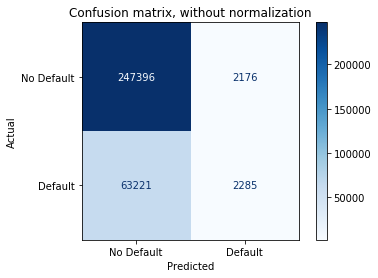

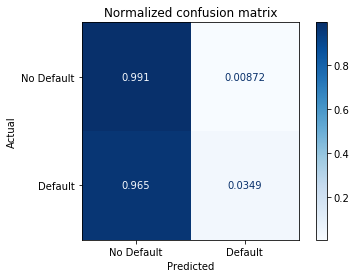

In [52]:
# example use of plotConfusionMatrix using gbc_model and X_test
# note: if you trained model using rfecv_selected_train, you need to call the function with rfecv_selected_test for X_test
plotConfusionMatrix('No Default', 'Default', lr_model, X_test, y_test)

# visualization

In [53]:
def plot_roc_curve_1 (model, model_name, X_test, y_test):
    from sklearn.metrics import roc_curve
    from sklearn.metrics import roc_auc_score
    from matplotlib import pyplot

    # generate a no skill prediction (majority class)
    ns_probs = [0 for _ in range(len(y_test))]

    # predict probabilities
    cf_probs = model.predict_proba(X_test)

    # keep probabilities for the positive outcome only
    cf_probs = cf_probs[:, 1]

    # calculate scores
    ns_auc = roc_auc_score(y_test, ns_probs)
    cf_auc = roc_auc_score(y_test, cf_probs)

    # summarize scores
    print('No Skill: ROC AUC=%.3f' % (ns_auc))
    print(model_name,': ROC AUC=%.3f' % (cf_auc))

    # calculate roc curves
    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    cf_fpr, cf_tpr, _ = roc_curve(y_test, cf_probs)

    # plot the roc curve for the model
    pyplot.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    pyplot.plot(cf_fpr, cf_tpr, marker='.', label=model_name)

    # axis labels
    pyplot.xlabel('False Positive Rate')
    pyplot.ylabel('True Positive Rate')

    # show the legend
    pyplot.legend()

    # show the plot
    pyplot.show()

No Skill: ROC AUC=0.500
dt_model : ROC AUC=0.687


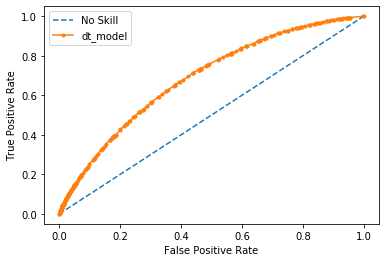

In [54]:
## example ROC plot for the decision tree model using X_test.
plot_roc_curve_1(lr_model, 'dt_model',  X_test, y_test)